### eBird API - Bird Data in Illinois (test)

Bird groups are defined according to the shared document.

**Test Time frame:** January 06, 2025 - January 06, 2025

Refer to API docs:  
https://documenter.getpostman.com/view/664302/S1ENwy59#intro

In [29]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import geopandas as gpd
import requests
from dotenv import load_dotenv
import os
from datetime import datetime, timedelta
import json
from pathlib import Path
# for i/o-bound processes
from concurrent.futures import ThreadPoolExecutor, as_completed
import re

In [2]:
load_dotenv()

True

##### Flat lookup dictionary - this defines the bird groups based on the bird species:

In [3]:
dabbling = [
  "Mallard",
  "American black duck",
  "Mallard Black duck hybrid", 
  "Gadwall", 
  "American wigeon", 
  "Northern pintail",
  "Northern shoveler",
  "Green-winged teal",
  "Blue-winged teal", 
  "Wood duck"
]

diving = [
  "Canvasback",
  "Redhead",
  "Ring-necked duck",
  "Greater scaup",
  "Lesser scaup",
  "Common goldeneye",
  "Bufflehead",
  "Long-tailed duck",
  "Ruddy duck",
  "White-winged scoter"
]

geese = [
	"Canada goose",
	"Snow goose",
	"Ross's goose",
	"Greater white-fronted goose",
	"Brant",
	"Red-breasted goose"
]

swans = [
	"Mute swan",
	"Trumpeter swan",
	"Tundra swan",
	"Black swan"
]

grebes = [
	"Pied-billed grebe",
	"Eared grebe"
]

herons_egrets = [
	"Great blue heron",
	"Great egret",
	"Green heron"
]

pelicans_cormorants = [
	"American white pelican",
	"Double-crested cormorant"
]

gulls_terns = [
	"Herring gull",
	"Ring-billed gull",
	"Caspian tern",
	"Common tern"
]

cranes = [
	"Sandhill crane",
	"Whooping crane"
]

raptors_hawks_eagles = [
	"Bald eagle",
	"Golden eagle",
	"Red-tailed hawk",
	"Red-shouldered hawk",
	"Cooper's hawk",
	"Sharp-shinned hawk",
	"Broad-winged hawk",
	"Rough-legged hawk",
	"Northern harrier"
]

raptors_falcons = [
	"Peregrine falcon",
	"American kestrel",
	"Osprey"
]

owls = [
	"Great horned owl",
	"Barred owl",
	"Eastern screech owl",
	"Snowy owl"
]

vultures = [
	"Turkey vulture",
	"Black vulture"
]

passerines = [
	"American robin",
	"Barn swallow",
	"Dark-eyed junco",
	"Hermit thrush",
	"Horned lark",
	"Red-winged blackbird",
	"Blue jay",
	"American crow",
	"Common raven",
	"European starling",
	"House sparrow"
]

pigeons_coots = [
	"Rock pigeon",
	"American coot"
]

all_bird_groups = [
	("Dabbling Ducks", dabbling),
	("Diving Ducks", diving),
	("Geese", geese),
	("Swans", swans),
	("Grebes", grebes),
	("Herons & Egrets", herons_egrets),
	("Pelicans & Cormorants", pelicans_cormorants),
	("Gulls & Terns", gulls_terns),
	("Cranes", cranes),
	("Raptors (Hawks & Eagles)", raptors_hawks_eagles),
	("Raptors (Falcons)", raptors_falcons),
	("Owls", owls),
	("Vultures", vultures),
	("Passerines", passerines),
	("Pigeons & Coots", pigeons_coots),
]

species_to_group = {
    species: group
    for group, species_list in all_bird_groups
    for species in species_list
}

species_to_group_norm = {k.lower(): v for k, v in species_to_group.items()}
species_to_group_norm

{'mallard': 'Dabbling Ducks',
 'american black duck': 'Dabbling Ducks',
 'mallard black duck hybrid': 'Dabbling Ducks',
 'gadwall': 'Dabbling Ducks',
 'american wigeon': 'Dabbling Ducks',
 'northern pintail': 'Dabbling Ducks',
 'northern shoveler': 'Dabbling Ducks',
 'green-winged teal': 'Dabbling Ducks',
 'blue-winged teal': 'Dabbling Ducks',
 'wood duck': 'Dabbling Ducks',
 'canvasback': 'Diving Ducks',
 'redhead': 'Diving Ducks',
 'ring-necked duck': 'Diving Ducks',
 'greater scaup': 'Diving Ducks',
 'lesser scaup': 'Diving Ducks',
 'common goldeneye': 'Diving Ducks',
 'bufflehead': 'Diving Ducks',
 'long-tailed duck': 'Diving Ducks',
 'ruddy duck': 'Diving Ducks',
 'white-winged scoter': 'Diving Ducks',
 'canada goose': 'Geese',
 'snow goose': 'Geese',
 "ross's goose": 'Geese',
 'greater white-fronted goose': 'Geese',
 'brant': 'Geese',
 'red-breasted goose': 'Geese',
 'mute swan': 'Swans',
 'trumpeter swan': 'Swans',
 'tundra swan': 'Swans',
 'black swan': 'Swans',
 'pied-billed g

##### Crowdsourced data eBird API - script:  
Revised Script 1/7/25

In [46]:
def get_bird_data_date(state: str, date: str) -> pd.DataFrame:
	'''
	Handles a single request (since I run this with ThreadPoolExecutor).\n
	Uses the historic data endpoint to pull observation data for specified state.\n
	Enter date in the following format: mm/dd/yy. Ex. 12/01/25

	Uses the following format:
	https://api.ebird.org/v2/data/obs/{state}-{county_fips}/historic/{y}/{m}/{d}
	'''

	api_key = os.getenv("EBIRD_API_KEY")
	headers = {'X-eBirdApiToken':api_key}

	cache_file = Path("cache") / f"{state}_{date.strftime("%Y-%m-%d")}.json"
	# check if i already pulled this data
	if cache_file.exists():
		with open(cache_file, "r") as f:
			return json.load(f)

	url = f"https://api.ebird.org/v2/data/obs/{state}/historic/{date.year}/{date.month:02}/{date.day:02}"
	# need full detail to get county
	response = requests.get(url, headers=headers, params={"detail": "full"}, timeout=60)

	if response.status_code == 200:
			day_data = response.json()
			with open(cache_file, "w") as f:
				json.dump(day_data, f)
			return day_data
	else:
		print(f"Failed {state} {date.date()} ({response.status_code})")
		return []

In [47]:
# now to test with illinois (fips 17) for a day period
start_date = datetime.strptime("01/06/26", "%m/%d/%y")
end_date = datetime.strptime("01/06/26", "%m/%d/%y")
state = "US-IL"

tasks = []
for day in range((end_date - start_date).days + 1):
	date = start_date + timedelta(days=day)
	tasks.append((date))

data = []	
with ThreadPoolExecutor(max_workers=4) as executor:
	futures = {executor.submit(get_bird_data_date, state, date): 
						(date) for date in tasks}
	for fut in as_completed(futures):
		# fut.result() -> pulled day data
		data.extend(fut.result())

full detail parameter gives us more information:

In [50]:
# this is the data cleaning and aggregating, which will be implemented in the final one-click function:
df = pd.DataFrame(data)
df["obsDt"] = pd.to_datetime(df["obsDt"], errors="coerce")

df.columns

Index(['speciesCode', 'comName', 'sciName', 'locId', 'locName', 'obsDt',
       'howMany', 'lat', 'lng', 'obsValid', 'obsReviewed', 'locationPrivate',
       'subId', 'subnational2Code', 'subnational2Name', 'subnational1Code',
       'subnational1Name', 'countryCode', 'countryName', 'userDisplayName',
       'obsId', 'checklistId', 'presenceNoted', 'hasComments', 'hasRichMedia',
       'firstName', 'lastName', 'exoticCategory'],
      dtype='object')

In [137]:
# aarsh's code - for county mapping:
def get_county_names(state_code: str) -> pd.DataFrame:
	"""
	Fetches a DataFrame mapping eBird county codes to county names
	input should be 'US-{state abbreviation here}'
	e.g., 'US-IL' -> dataframe of subnational2 code and county name
	"""
	api_key = os.getenv("EBIRD_API_KEY")
	headers = {'X-eBirdApiToken':api_key}
	url = f"https://api.ebird.org/v2/ref/region/list/subnational2/{state_code}"
	response = requests.get(url, headers=headers, timeout=60)
	if response.status_code == 200:
			return pd.DataFrame(response.json())
	return pd.DataFrame(columns=["code", "name"])

In [136]:
county_codes = get_county_names("US-IL")
county_codes

,code,name
0,US-IL-001,Adams
1,US-IL-003,Alexander
2,US-IL-005,Bond
3,US-IL-007,Boone
4,US-IL-009,Brown
...,...,...
97,US-IL-195,Whiteside
98,US-IL-197,Will
99,US-IL-199,Williamson
100,US-IL-201,Winnebago


now that I have the county names and code I can merge:

In [51]:
duck_df = df.merge(county_codes, left_on="subnational2Code", right_on="code", how="left")

In [ ]:
weekly_summary = (
		duck_df.groupby(
				[
				# modification here - label="left" ensures week_starting starts monday
				pd.Grouper(key="obsDt", freq="W-MON", label="left", closed="left"),
				"name",
				"comName",
        ],
				dropna=False,
		)["howMany"]
		.sum(min_count=1)
		.reset_index()
)

weekly_summary.columns = ["Week_Starting", "County", "Species", "Total_Count"]
weekly_summary["Total_Count"] = weekly_summary["Total_Count"].fillna(0).astype(int)

In [ ]:
weekly_summary["Species_norm"] = weekly_summary["Species"].str.lower()

# normalizing so i can map to the correct bird group without losing data due to formatting
# v = species, v = respective bird group
# so this assigns brid group for each k,v pair in species to group lookup dict
species_to_group_norm = {k.lower(): v for k, v in species_to_group.items()}

weekly_summary["Bird_Group"] = (weekly_summary["Species_norm"].map(species_to_group_norm))

weekly_summary = weekly_summary.dropna() # note: for the purposes of this analysis I am dropping any species with na values if not found

important note: a `total_count` of 0 means species were observed but not counted.

In [79]:
weekly_summary

,Week_Starting,County,Species,Total_Count,Bird_Group,Species_norm
4,2026-01-05,Boone,Great Horned Owl,1,Owls,great horned owl
5,2026-01-05,Champaign,American Wigeon,2,Dabbling Ducks,american wigeon
6,2026-01-05,Champaign,Gadwall,2,Dabbling Ducks,gadwall
7,2026-01-05,Champaign,Northern Pintail,1,Dabbling Ducks,northern pintail
8,2026-01-05,Champaign,Red-tailed Hawk,1,Raptors (Hawks & Eagles),red-tailed hawk
9,2026-01-05,Champaign,Redhead,2,Diving Ducks,redhead
11,2026-01-05,Cook,American Coot,5,Pigeons & Coots,american coot
12,2026-01-05,Cook,American Crow,2,Passerines,american crow
14,2026-01-05,Cook,American Robin,3,Passerines,american robin
17,2026-01-05,Cook,Blue Jay,2,Passerines,blue jay


now I can get the polygon data for each county, to plot it.

In [86]:
us_states = gpd.read_file("./shapefiles/tl_2025_us_county.zip")
il_counties = us_states[us_states["STATEFP"]=="17"]
il_counties

,STATEFP,COUNTYFP,COUNTYNS,GEOID,GEOIDFQ,NAME,NAMELSAD,LSAD,CLASSFP,MTFCC,CSAFP,CBSAFP,METDIVFP,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry
81,17,015,00424209,17015,0500000US17015,Carroll,Carroll County,06,H1,G4020,None,None,None,A,1153597409,55881823,+42.0708996,-089.9241898,"POLYGON ((-89.97844 41.93119, -89.97845 41.931..."
87,17,043,00422191,17043,0500000US17043,DuPage,DuPage County,06,H1,G4020,176,16980,16984,A,849236415,22006224,+41.8520577,-088.0860389,"POLYGON ((-87.9202 41.95326, -87.9202 41.95321..."
122,17,133,01784865,17133,0500000US17133,Monroe,Monroe County,06,H1,G4020,476,41180,None,A,997924032,33756312,+38.2779831,-090.1790777,"POLYGON ((-89.98458 38.30842, -89.9843 38.3084..."
135,17,157,01784967,17157,0500000US17157,Randolph,Randolph County,06,H1,G4020,None,None,None,A,1490194102,56150220,+38.0565149,-089.8212096,"POLYGON ((-89.59507 37.95534, -89.59791 37.950..."
145,17,149,01784941,17149,0500000US17149,Pike,Pike County,06,H1,G4020,None,None,None,A,2153190712,45251538,+39.6251059,-090.8890344,"POLYGON ((-90.91667 39.84493, -90.91661 39.844..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3126,17,007,00424205,17007,0500000US17007,Boone,Boone County,06,H1,G4020,466,40420,None,A,727137091,3338156,+42.3189831,-088.8242951,"POLYGON ((-88.70547 42.24077, -88.70543 42.233..."
3131,17,137,00424270,17137,0500000US17137,Morgan,Morgan County,06,H1,G4020,522,27300,None,A,1473595806,9053547,+39.7176572,-090.2049929,"POLYGON ((-90.08049 39.52104, -90.08759 39.520..."
3158,17,161,00424282,17161,0500000US17161,Rock Island,Rock Island County,06,H1,G4020,209,19340,None,A,1107212317,61631338,+41.4684205,-090.5721252,"POLYGON ((-90.33554 41.67248, -90.3355 41.6729..."
3177,17,111,01784815,17111,0500000US17111,McHenry,McHenry County,06,H1,G4020,176,16980,16984,A,1562806157,19855932,+42.3242982,-088.4522450,"POLYGON ((-88.35442 42.154, -88.35929 42.154, ..."


In [97]:
merged = weekly_summary.merge(il_counties, how="inner", left_on="County", right_on="NAME")
gdf_merged = gpd.GeoDataFrame(merged, geometry="geometry", crs=il_counties.crs)
gdf_merged.columns

Index(['Week_Starting', 'County', 'Species', 'Total_Count', 'Bird_Group',
       'Species_norm', 'STATEFP', 'COUNTYFP', 'COUNTYNS', 'GEOID', 'GEOIDFQ',
       'NAME', 'NAMELSAD', 'LSAD', 'CLASSFP', 'MTFCC', 'CSAFP', 'CBSAFP',
       'METDIVFP', 'FUNCSTAT', 'ALAND', 'AWATER', 'INTPTLAT', 'INTPTLON',
       'geometry'],
      dtype='object')

##### Finalized script:

In [ ]:
# ALL HELPERS #

def get_bird_data_date(state: str, date: str, headers: dict) -> list:
	'''
	Handles a single request (since I run this with ThreadPoolExecutor).\n
	Uses the historic data endpoint to pull observation data for specified state.\n
	Enter date in the following format: mm/dd/yy. Ex. 12/01/25

	Uses the following format:
	https://api.ebird.org/v2/data/obs/{state}-{county_fips}/historic/{y}/{m}/{d}
	'''
	cache_file = Path("cache") / f"{state}_{date.strftime("%Y-%m-%d")}.json"
	# check if i already pulled this data
	if cache_file.exists():
		with open(cache_file, "r") as f:
			return json.load(f)
	url = f"https://api.ebird.org/v2/data/obs/{state}/historic/{date.year}/{date.month:02}/{date.day:02}"
	# need full detail to get county name and merge later.
	response = requests.get(url, headers=headers, params={"detail": "full"}, timeout=60)
	if response.status_code == 200:
			day_data = response.json()
			with open(cache_file, "w") as f:
				json.dump(day_data, f)
			return day_data
	else:
		print(f"Failed {state} {date.date()} ({response.status_code})")
		return []

def get_data_as_df(start_date:str, end_date:str, state:str) -> pd.DataFrame:
	load_dotenv()
	api_key = os.getenv("EBIRD_API_KEY")
	headers = {'X-eBirdApiToken':api_key}

	start_date = datetime.strptime(start_date, "%m/%d/%y")
	end_date = datetime.strptime(end_date, "%m/%d/%y")

	dates = []
	for day in range((end_date - start_date).days + 1):
		d = start_date + timedelta(days=day)
		dates.append(d)

	data = []	
	with ThreadPoolExecutor(max_workers=4) as executor:
		futures = [executor.submit(get_bird_data_date, state, d, headers) for d in dates]
		for fut in as_completed(futures):
			# fut.result() is our pulled day data
			data.extend(fut.result())

	return pd.DataFrame(data)

# aarsh's code - for county mapping:
def get_county_names(state_code: str) -> pd.DataFrame:
	'''
	Fetches a DataFrame mapping eBird county codes to county names
	e.g., 'US-IL-031' -> 'Cook'
	'''
	api_key = os.getenv("EBIRD_API_KEY")
	headers = {'X-eBirdApiToken':api_key}
	url = f"https://api.ebird.org/v2/ref/region/list/subnational2/{state_code}"
	response = requests.get(url, headers=headers, timeout=60)
	if response.status_code == 200:
			return pd.DataFrame(response.json())
	return pd.DataFrame(columns=["code", "name"])

def get_weekly_summary(start_date:str, end_date:str, ebird_state:str, state_fips: str) -> gpd.GeoDataFrame:
	'''
	Data is FIRST grouped in the following format:\n
	Week Starting | County | Species Group | Total Count\n
	Returns a finalized GeoDataFrame to plot the weekly summary.
	'''
	gdf = get_data_as_df(start_date, end_date, ebird_state)
	gdf["obsDt"] = pd.to_datetime(gdf["obsDt"], errors="coerce")
	county_codes = get_county_names(ebird_state)
	birds = gdf.merge(county_codes, left_on="subnational2Code", right_on="code", how="left")

	weekly_summary = (
		birds.groupby(
		# week starts at monday
		[pd.Grouper(key="obsDt", freq="W-MON", label="left", closed="left"), "name", "comName"],
		dropna=False)["howMany"].sum(min_count=1).reset_index()
	)
	
	# note: a `Total_Count` of 0 means species were observed but not counted.
	weekly_summary.columns = ["Week_Starting", "County", "Species", "Total_Count"]
	weekly_summary["Total_Count"] = weekly_summary["Total_Count"].fillna(0).astype(int)
	weekly_summary["Species_norm"] = weekly_summary["Species"].str.lower()
	weekly_summary["Bird_Group"] = (weekly_summary["Species_norm"].map(species_to_group_norm))

	# note: for the purposes of this analysis I am dropping any species with na values if not found
	# this is because they are not species of interest
	weekly_summary = weekly_summary.dropna() 

	us_states = gpd.read_file("./shapefiles/tl_2025_us_county.zip")
	il_counties = us_states[us_states["STATEFP"]==f"{state_fips}"]

	merged = weekly_summary.merge(il_counties, how="inner", left_on="County", right_on="NAME")

	gdf_merged = gpd.GeoDataFrame(merged, geometry="geometry", crs=il_counties.crs)
	gdf_merged = gdf_merged.to_crs(il_counties.crs)
	
	# only keep these columns
	cols_to_keep = ['Week_Starting', 'County', 'Species', 'Total_Count', 'Bird_Group', 'Species_norm', 'geometry']
	gdf_merged = gdf_merged[cols_to_keep]

	return gdf_merged

Now moving onto the plotting function, which saves all plots for the identified bird groups and period under a folder. 

In [ ]:
start_date="01/06/26"
end_date="01/06/26"
ebird_state_code="US-IL"

In [76]:
gdf = get_weekly_summary(start_date, end_date, ebird_state_code, "17")
summary_bird_groups = gdf["Bird_Group"].unique()

In [77]:
gdf.head()

,Week_Starting,County,Species,Total_Count,Bird_Group,Species_norm,geometry
0,2026-01-05,Adams,Blue Jay,1,Passerines,blue jay,"POLYGON ((-91.02742 40.19447, -91.02438 40.194..."
1,2026-01-05,Adams,Dark-eyed Junco,2,Passerines,dark-eyed junco,"POLYGON ((-91.02742 40.19447, -91.02438 40.194..."
2,2026-01-05,Adams,European Starling,3,Passerines,european starling,"POLYGON ((-91.02742 40.19447, -91.02438 40.194..."
3,2026-01-05,Adams,House Sparrow,18,Passerines,house sparrow,"POLYGON ((-91.02742 40.19447, -91.02438 40.194..."
4,2026-01-05,Boone,Great Horned Owl,1,Owls,great horned owl,"POLYGON ((-88.70547 42.24077, -88.70543 42.233..."


In [85]:
group_gdf

,County,Total_Count
0,union,6
1,white,3
2,williamson,3


c:\Users\ITO\Desktop\bird_species\.venv\Lib\site-packages\geopandas\geodataframe.py:1969: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


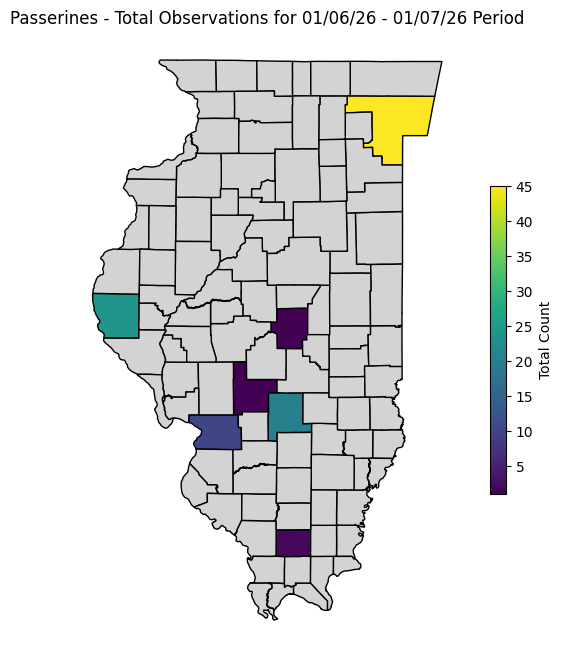

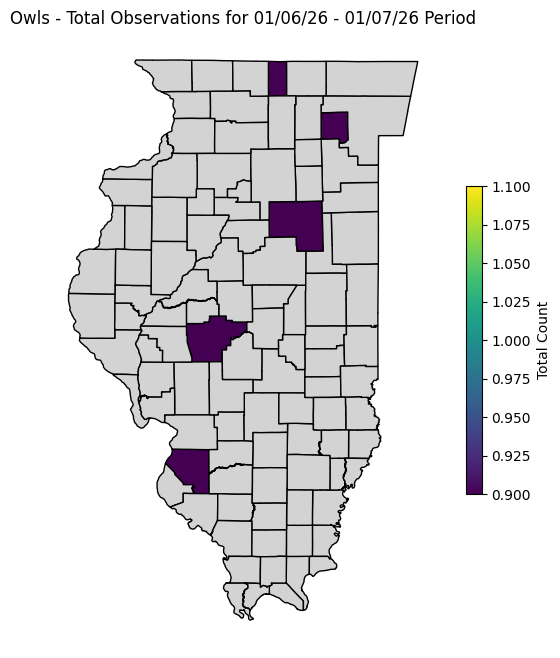

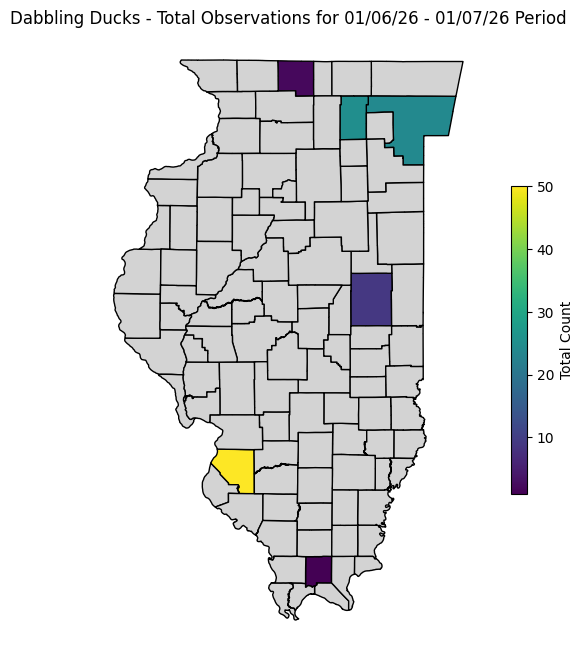

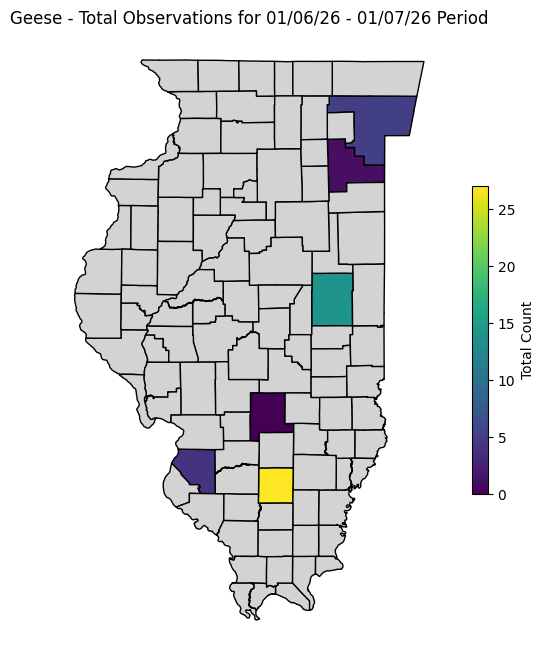

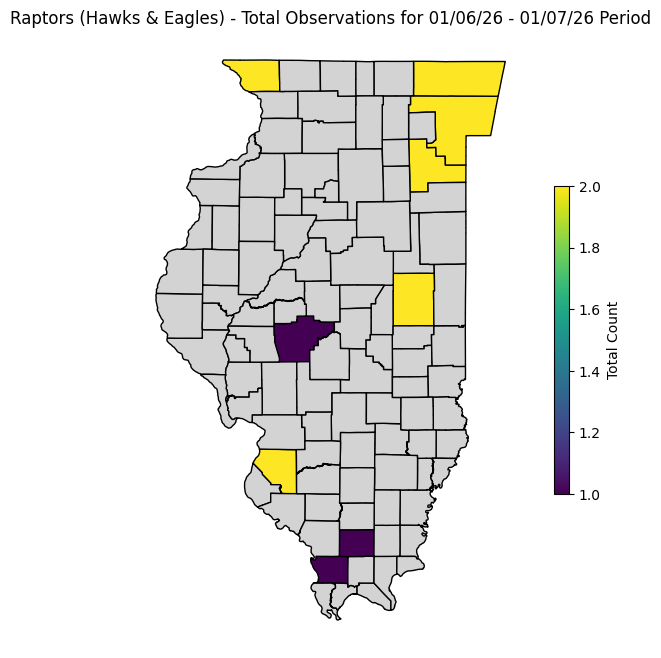

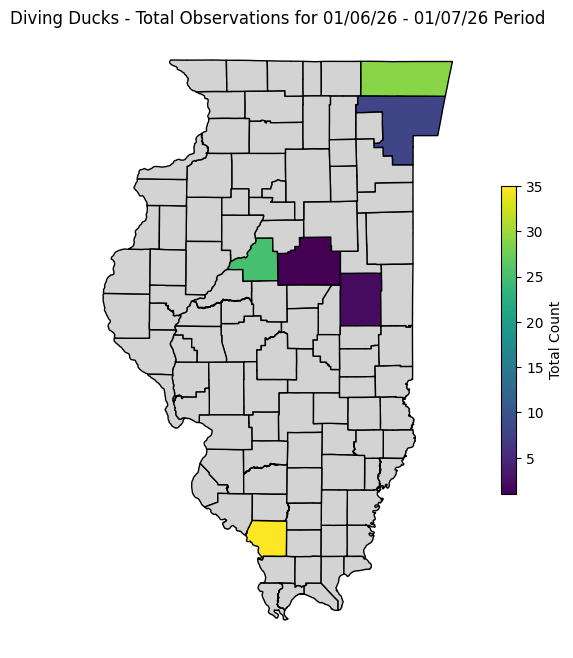

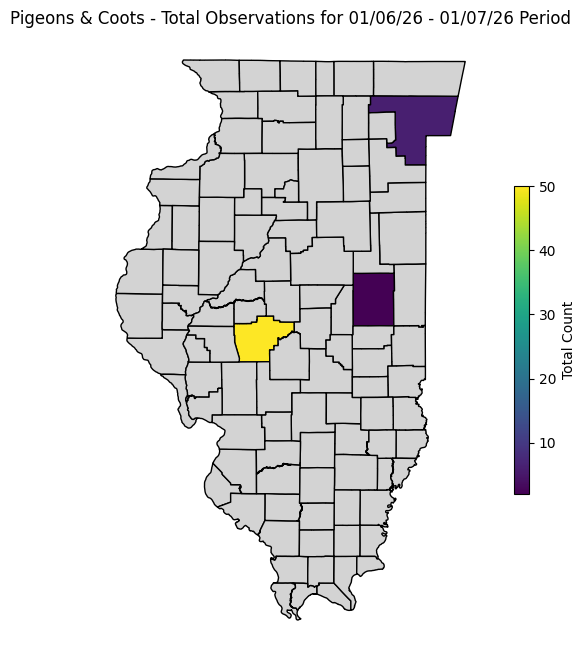

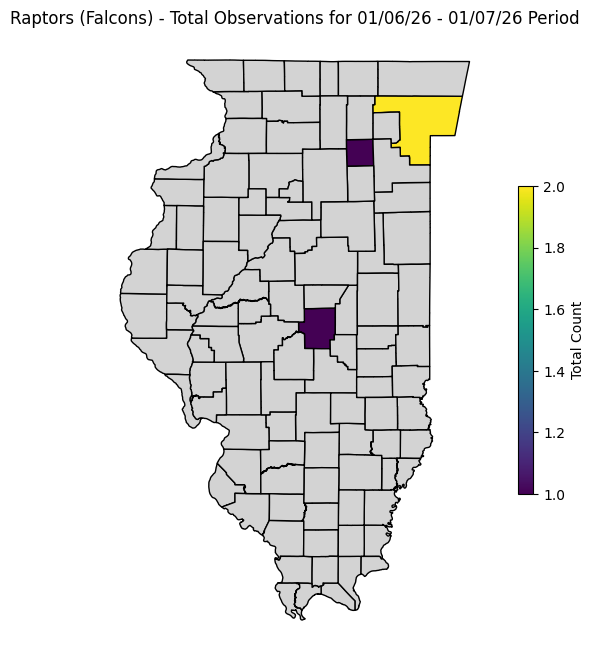

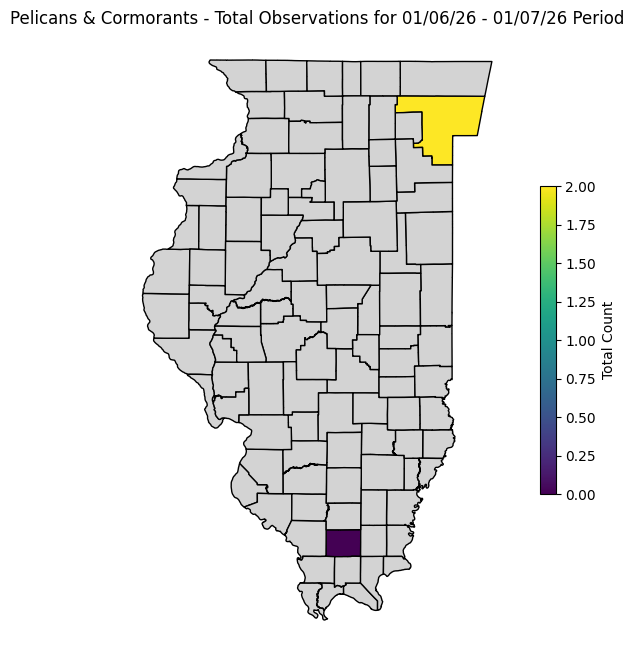

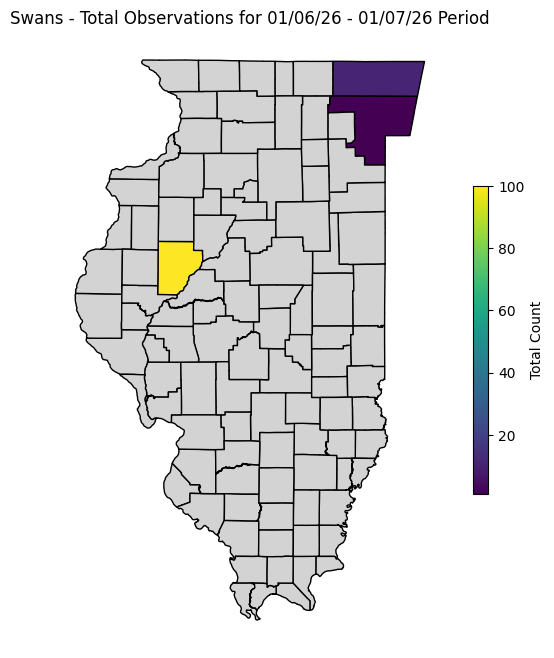

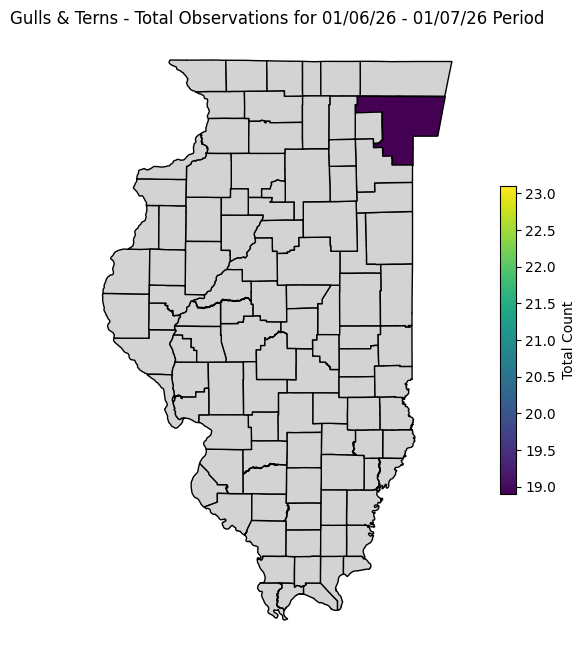

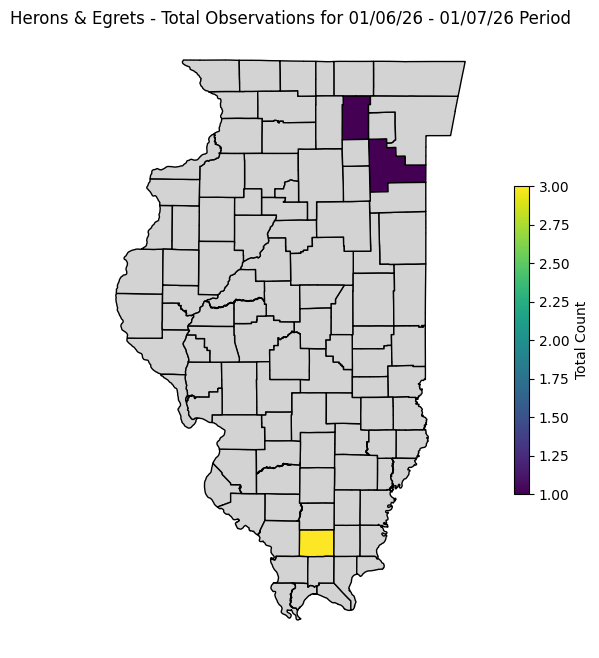

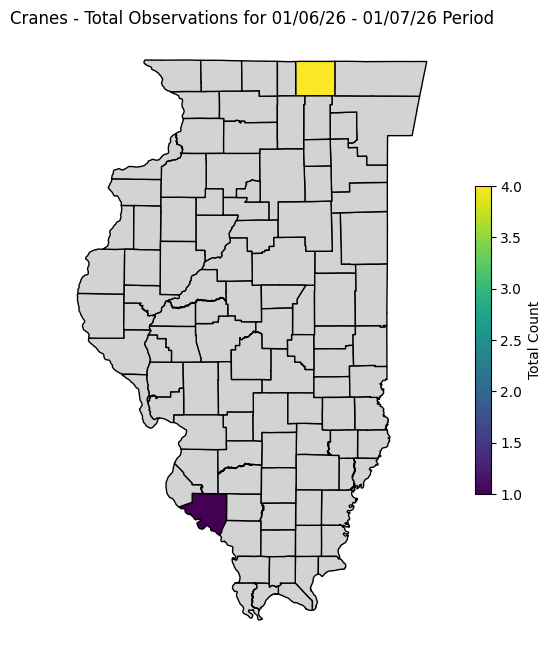

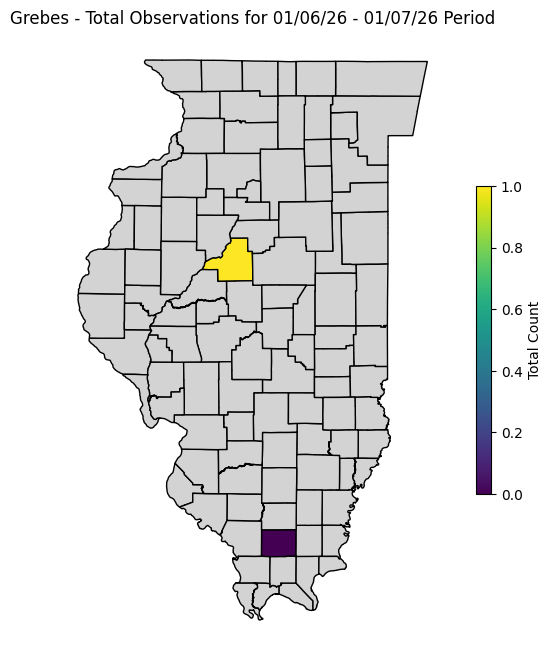

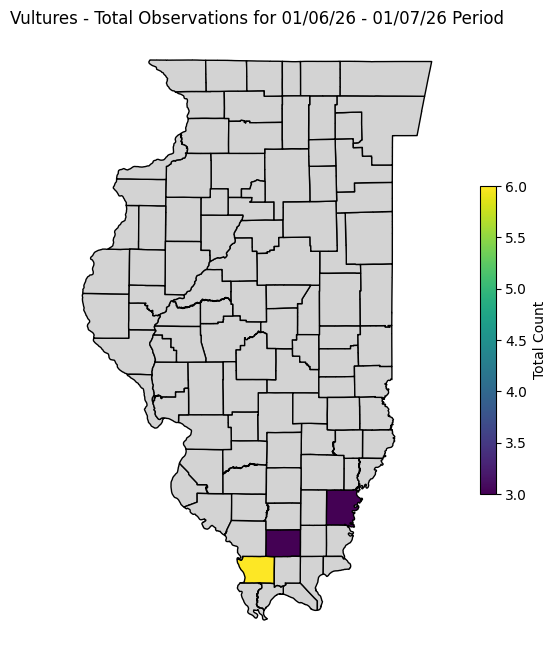

In [89]:
# overlay the illinois map.
# fig, ax = plt.subplots(figsize=(8, 8))

us_states = gpd.read_file("./shapefiles/tl_2025_us_county.zip")
il_counties = us_states[us_states["STATEFP"]=="17"]
il_counties["County"] = il_counties["NAME"].str.lower()  # adjust to lower case

for g in summary_bird_groups:
	# first groupby county and agg sum total_count val
	group_gdf = (gdf[gdf["Bird_Group"]==g].groupby("County", as_index=False).agg({"Total_Count":"sum"}))
	group_gdf["County"] = group_gdf["County"].str.lower()

	merged_gdf = il_counties.merge(group_gdf, on="County", how="left")

	fig, ax = plt.subplots(figsize=(8, 8))

	# merged_gdf.boundary.plot(ax=ax, color="black")
	merged_gdf.plot(
		column="Total_Count",
		cmap="viridis",
		edgecolor="black",
		legend=True,
		ax=ax,
		missing_kwds={
			"color":"lightgrey",
			"label":"No observations"
		},
		legend_kwds={
			"shrink":0.5,
			"label":"Total Count",
		}
	)

	ax.set_title(f"{g} - Total Observations for {start_date} - {end_date} Period", fontsize=12)
	ax.axis("off")

	# output_path = Path(f"maps/{start_date.replace("/","-")}-{end_date.replace("/","-")}_maps_{ebird_state_code}")
	# output_path.mkdir(parents=True, exist_ok=True)

	# save this current graph
	# plt.savefig(output_path / f"{g}.png")

In [91]:
def create_maps_for_dates(start_date: str, end_date: str, ebird_state_code: str, state_fips: str) -> list:
	'''
	Master function to create the maps for the given date range, eBird API state code, and state fips code.\n
	note: This function does not handle the API requests but uses helper functions to do so.\n
	Example:\n
	`start_date` of "01/06/26", `end_date` of "01/07/26", `ebird_state_code` of "US-IL", `state_fips` of "17".\n
	Saves \n
	'''
	Path("maps").mkdir(parents=True, exist_ok=True)
	output_path = Path(f"maps/{start_date.replace("/","-")}-{end_date.replace("/","-")}_maps_{ebird_state_code}")
	output_path.mkdir(parents=True, exist_ok=True)
	
	gdf = get_weekly_summary(start_date, end_date, ebird_state_code, state_fips)
	summary_bird_groups = gdf["Bird_Group"].unique()

	# overlay the illinois map.
	us_states = gpd.read_file("./shapefiles/tl_2025_us_county.zip")
	il_counties = us_states[us_states["STATEFP"]==state_fips]
	il_counties["County"] = il_counties["NAME"].str.lower() # adjust to lower case to merge

	for g in summary_bird_groups:
		# first groupby county and agg sum total_count val
		group_gdf = (gdf[gdf["Bird_Group"]==g].groupby("County", as_index=False).agg({"Total_Count":"sum"}))
		group_gdf["County"] = group_gdf["County"].str.lower()

		merged_gdf = il_counties.merge(group_gdf, on="County", how="left")

		fig, ax = plt.subplots(figsize=(8, 8))

		# merged_gdf.boundary.plot(ax=ax, color="black")
		merged_gdf.plot(
			column="Total_Count",
			cmap="viridis",
			edgecolor="black",
			legend=True,
			ax=ax,
			missing_kwds={
				"color":"lightgrey",
				"label":"No observations"
			},
			legend_kwds={
				"shrink":0.5,
				"label":"Total Count",
			}
		)

		ax.set_title(f"{g} - Total Observations for {start_date} - {end_date} Period", fontsize=12)
		ax.axis("off")

		output_path = Path(f"maps/{start_date.replace("/","-")}-{end_date.replace("/","-")}_maps_{ebird_state_code}")
		output_path.mkdir(parents=True, exist_ok=True)

		# save this current graph
		plt.savefig(output_path / f"{g}.png")

c:\Users\ITO\Desktop\bird_species\.venv\Lib\site-packages\geopandas\geodataframe.py:1969: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


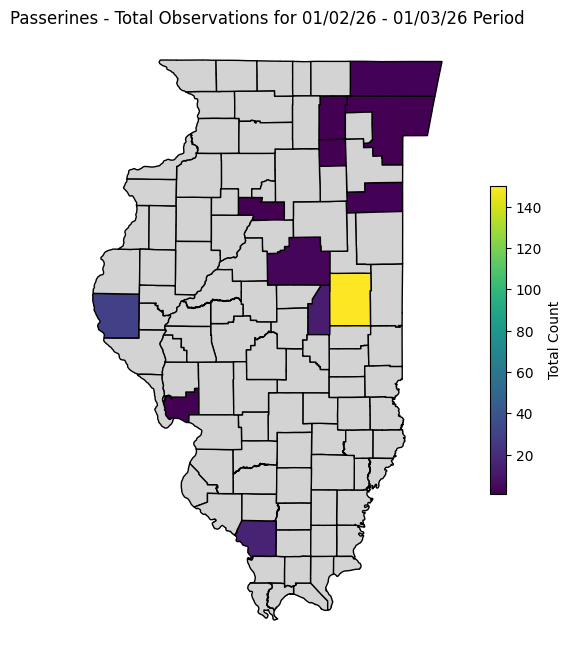

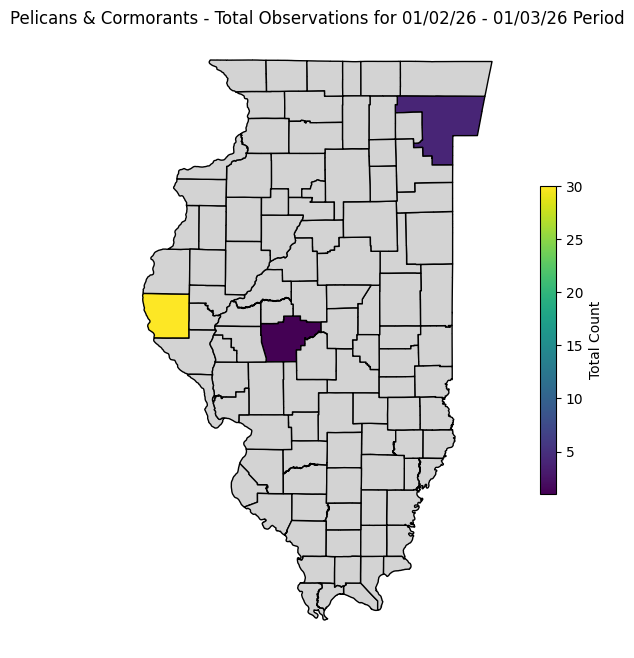

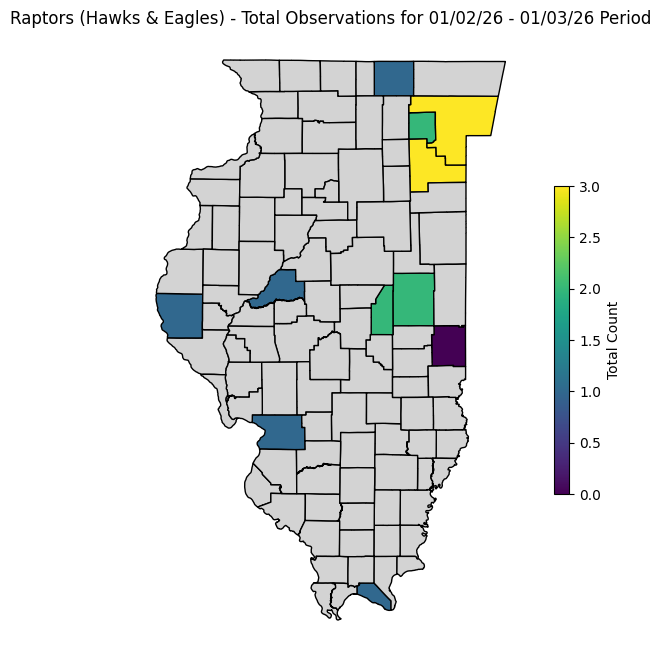

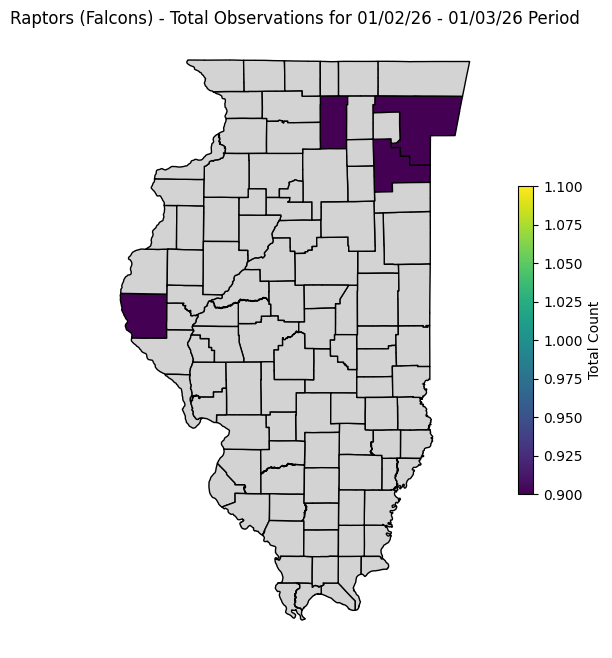

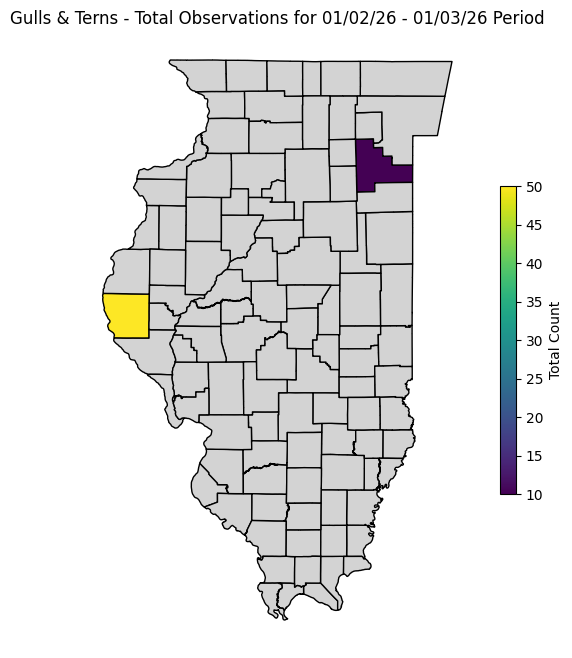

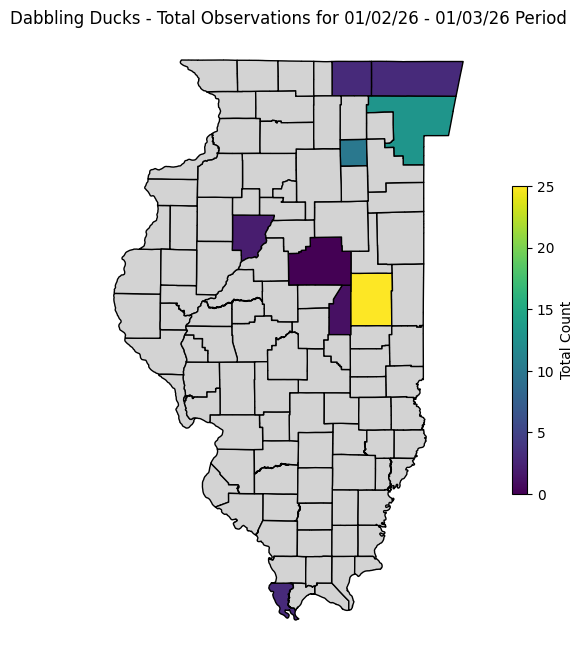

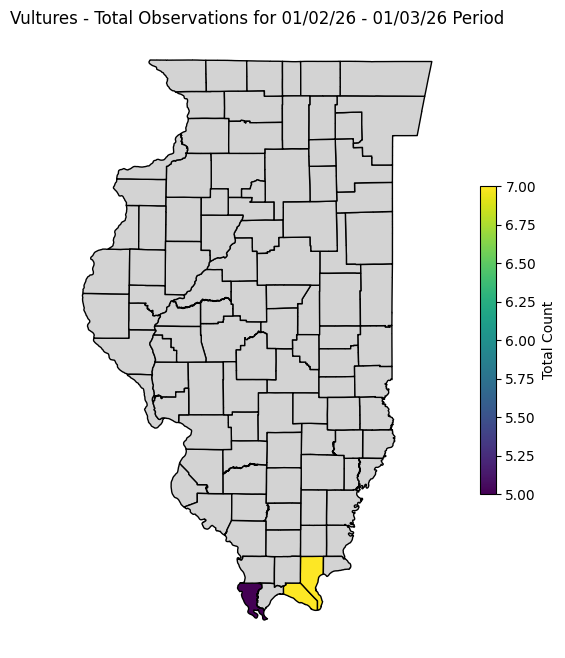

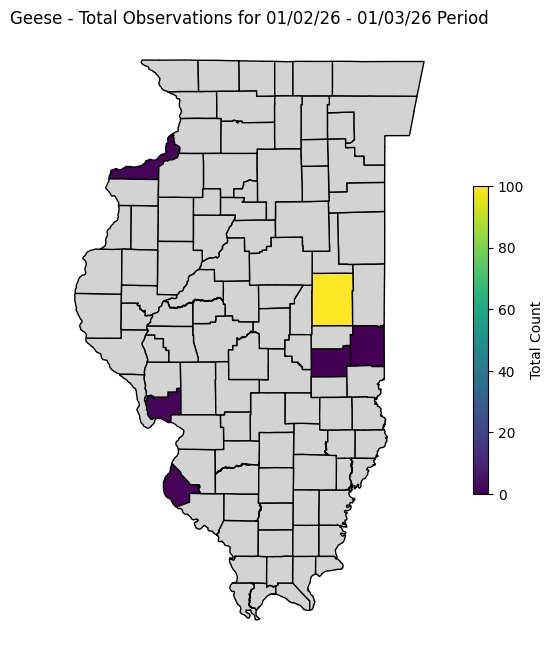

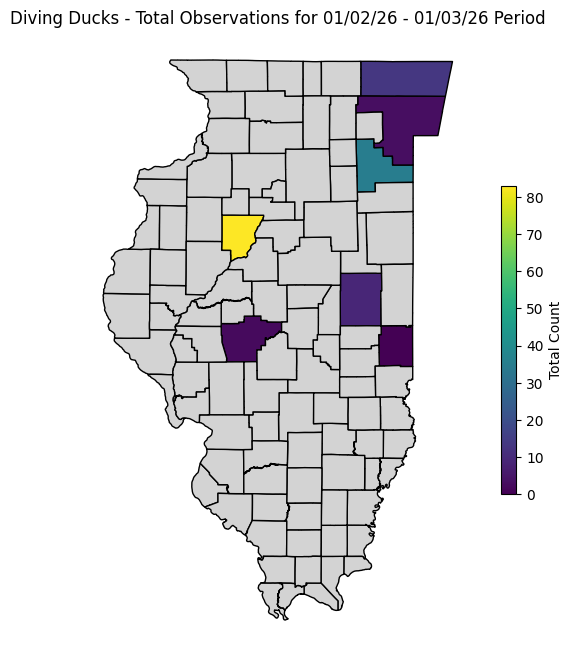

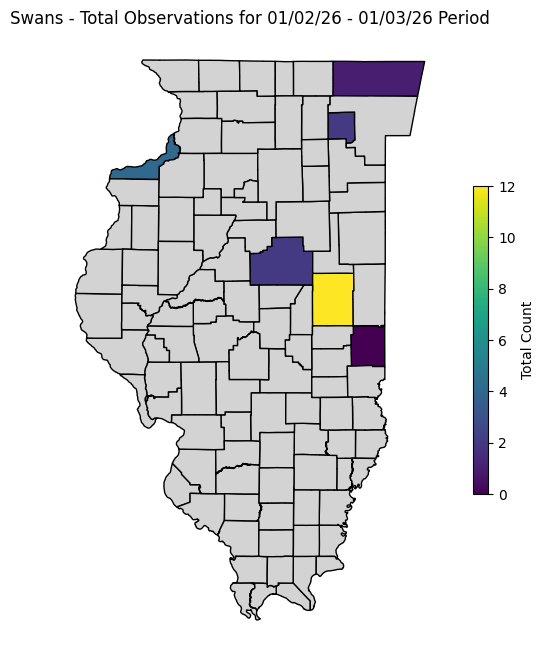

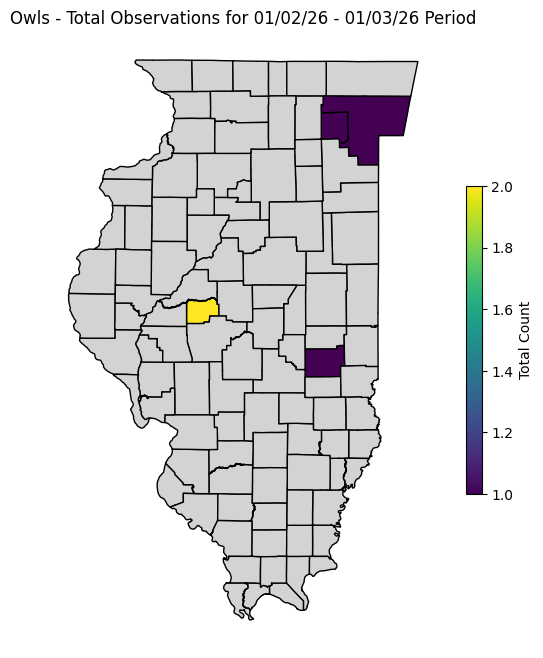

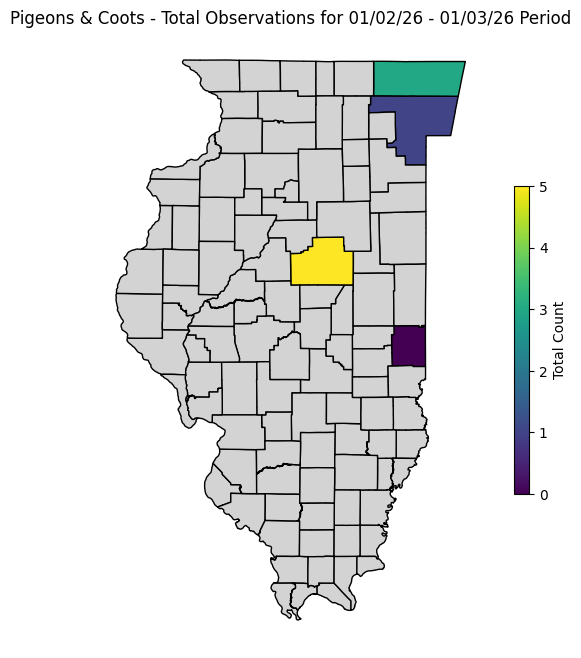

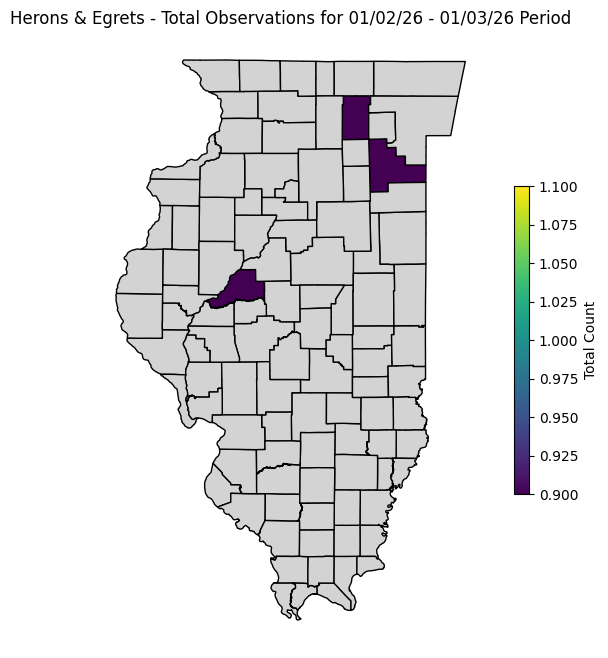

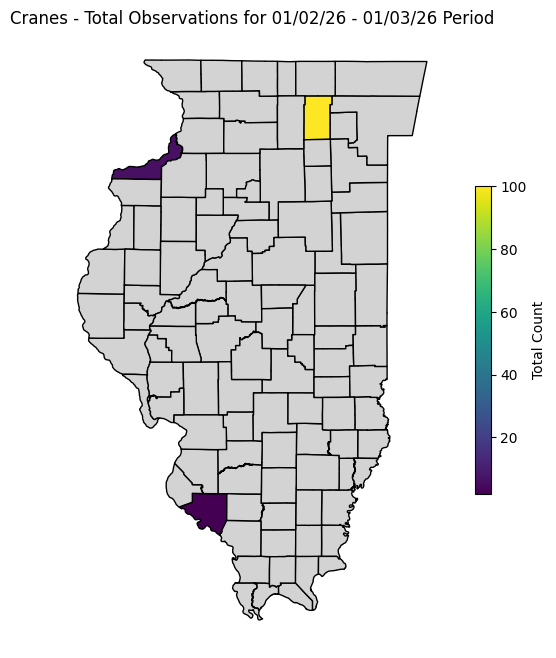

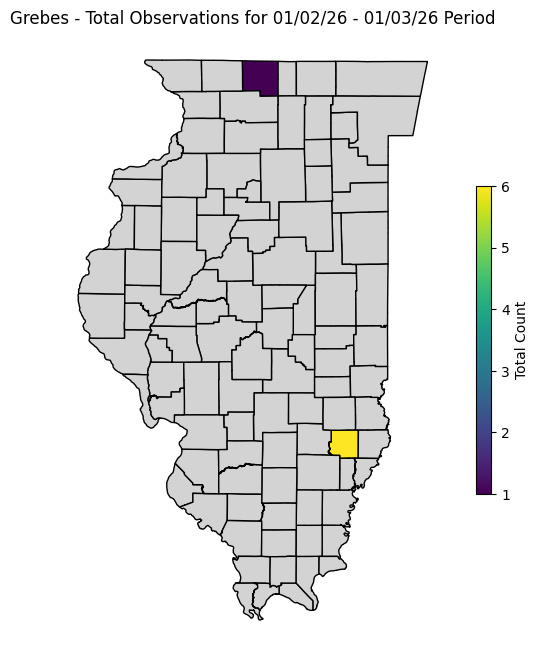

In [93]:
create_maps_for_dates("01/02/26","01/03/26","US-IL", "17")